In [1]:
%reload_ext autoreload
%autoreload 2

from Preprocessor import *
from CNNDiscriminator import *

%aimport Preprocessor
%aimport CNNDiscriminator

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import time
import pandas as pd
import os
import copy
from matplotlib import pyplot as plt
import re
import string
import nltk

In [2]:
class MyDataset(Dataset):
    def __init__(self, values, labels):
        super(MyDataset, self).__init__()
        self.values = values
        self.labels = labels

    def __len__(self):
        return len(self.values)

    def __getitem__(self, index):
        return self.values[index], self.labels[index]

In [3]:
discriminator = CNNDiscriminator.CNNDiscriminator()
test = torch.randint(low=0,high=50,size=(8,5)) # 8 sentences of 5 words
display(test)
a = discriminator(test)
display(a)

tensor([[38,  2, 30, 26, 31],
        [38, 34, 13, 20,  1],
        [44,  9, 14,  9,  5],
        [32, 15, 38, 20,  5],
        [41, 25, 44, 30, 41],
        [28, 18,  9,  9, 25],
        [18, 46,  3,  5, 33],
        [ 2, 48,  7, 27, 29]])

tensor([[2.5123e-08, 1.0000e+00],
        [6.9469e-06, 9.9999e-01],
        [3.3306e-06, 1.0000e+00],
        [2.0633e-06, 1.0000e+00],
        [9.2026e-10, 1.0000e+00],
        [1.2190e-12, 1.0000e+00],
        [1.1586e-04, 9.9988e-01],
        [2.2434e-10, 1.0000e+00]], grad_fn=<SoftmaxBackward>)

In [4]:
# Training part : features needed
num_epochs = 1
num_classes = 2
batch_size = 8
learning_rate = 0.001

criterion = nn.BCELoss() # nn.BCEWithLogitsLoss stabler ? 

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Beta1 hyperparam for Adam optimizers
# beta1 = 0.5
# optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# Create a batch of data
samples = torch.randint(low=0,high=50,size=(400,5))
labels = torch.randint(low=0,high=2,size=(samples.size(0),1)).float() 
train_dataset = MyDataset(samples, labels)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [5]:
# Training
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    
    for i, (sentences, labels) in enumerate(train_loader):
        
        # Run the forward pass
        outputs = discriminator(sentences)
        true_probability = outputs[:,1].unsqueeze(1)
        loss = criterion(true_probability, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data,1)
        predicted = predicted.unsqueeze(1)
        correct = (predicted == labels).sum().item() 
        acc_list.append(correct / total)
        
        # Print the results 
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/1], Step [1/50], Loss: 9.0978, Accuracy: 25.00%
Epoch [1/1], Step [2/50], Loss: 8.4065, Accuracy: 37.50%
Epoch [1/1], Step [3/50], Loss: 4.3701, Accuracy: 75.00%
Epoch [1/1], Step [4/50], Loss: 3.8432, Accuracy: 37.50%
Epoch [1/1], Step [5/50], Loss: 2.9909, Accuracy: 37.50%
Epoch [1/1], Step [6/50], Loss: 5.0308, Accuracy: 25.00%
Epoch [1/1], Step [7/50], Loss: 1.0658, Accuracy: 75.00%
Epoch [1/1], Step [8/50], Loss: 3.0583, Accuracy: 62.50%
Epoch [1/1], Step [9/50], Loss: 3.9535, Accuracy: 37.50%
Epoch [1/1], Step [10/50], Loss: 1.5474, Accuracy: 37.50%
Epoch [1/1], Step [11/50], Loss: 2.8475, Accuracy: 50.00%
Epoch [1/1], Step [12/50], Loss: 8.0559, Accuracy: 12.50%
Epoch [1/1], Step [13/50], Loss: 2.9040, Accuracy: 37.50%
Epoch [1/1], Step [14/50], Loss: 1.1723, Accuracy: 75.00%
Epoch [1/1], Step [15/50], Loss: 2.7519, Accuracy: 50.00%
Epoch [1/1], Step [16/50], Loss: 8.0014, Accuracy: 25.00%
Epoch [1/1], Step [17/50], Loss: 4.0964, Accuracy: 37.50%
Epoch [1/1], Step [18/5

In [13]:
preprocessor = Preprocessor.Preprocessor()
preprocessor.load_dataset('data.xls') # Load the dataset
output_sentences, output_descriptions = preprocessor.preprocess()

In [14]:
display(output_descriptions.shape, output_sentences.shape)
# display(d[0], s[0])

vocabulary = preprocessor.vocabulary
display(len(vocabulary))

desc_original = preprocessor.descriptions_original
# display(desc_original[9])

desc_tokened = preprocessor.descriptions_tokened
sent_tokened = preprocessor.sentences_tokened
# display(desc_tokened[9])

desc_numeric = preprocessor.descriptions_indexed
sent_numeric = preprocessor.sentences_indexed
# display(desc_numeric[9])

torch.Size([4115, 200])

torch.Size([41220, 20])

25254

31733

16130

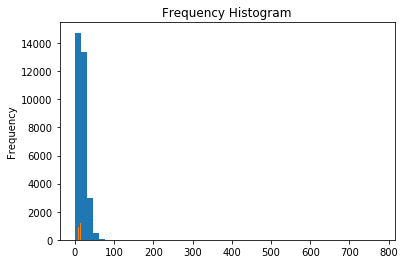

In [18]:
# Test divers size distribution avec desc_numeric or sent_numeric
display(len(sent_numeric))

lens = [len(d) for d in sent_numeric]
plt.hist(lens, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
# u,c = np.unique(lens, return_counts=True)
# display(u,c)

lens_filtered = [l for l in lens if 5 <= l <= 20]
display(len(lens_filtered))
plt.hist(lens_filtered, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [20]:
# Quick training test for the text
samples = output_sentences
labels = torch.randint(low=0,high=2,size=(samples.size(0),1)).float() 
train_dataset = MyDataset(samples, labels)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
discri_test2 = CNNDiscriminator.CNNDiscriminator(voc_size=len(vocabulary)+1)

total_step = len(train_loader)
loss_list = []
acc_list = []

for epoch in range(num_epochs):
    
    for i, (sentences, labels) in enumerate(train_loader):
        
        # Run the forward pass
        outputs = discri_test2(sentences)
        true_probability = outputs[:,1].unsqueeze(1)
        loss = criterion(true_probability, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data,1)
        predicted = predicted.unsqueeze(1)
        correct = (predicted == labels).sum().item() 
        acc_list.append(correct / total)
        
        # Print the results 
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/1], Step [1/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [2/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [3/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [5/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [6/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [7/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [8/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [9/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [10/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [11/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [12/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [13/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [14/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [15/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [16/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [17/5153], Loss: 17

Epoch [1/1], Step [135/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [136/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [137/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [138/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [139/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [140/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [141/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [142/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [143/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [144/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [145/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [146/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [147/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [148/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [149/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [150/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/

Epoch [1/1], Step [267/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [268/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [269/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [270/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [271/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [272/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [273/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [274/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [275/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [276/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [277/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [278/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [279/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [280/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [281/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [282/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1

Epoch [1/1], Step [399/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [400/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [401/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [402/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [403/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [404/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [405/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [406/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [407/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [408/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [409/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [410/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [411/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [412/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [413/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [414/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1

Epoch [1/1], Step [531/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [532/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [533/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [534/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [535/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [536/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [537/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [538/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [539/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [540/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [541/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [542/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [543/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [544/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [545/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [546/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1]

Epoch [1/1], Step [663/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [664/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [665/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [666/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [667/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [668/5153], Loss: 27.6310, Accuracy: 0.00%
Epoch [1/1], Step [669/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [670/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [671/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [672/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [673/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [674/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [675/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [676/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [677/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [678/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1]

Epoch [1/1], Step [795/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [796/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [797/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [798/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [799/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [800/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [801/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [802/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [803/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [804/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [805/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [806/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [807/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [808/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [809/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [810/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1]

Epoch [1/1], Step [927/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [928/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [929/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [930/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [931/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [932/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [933/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [934/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [935/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [936/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [937/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [938/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [939/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [940/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [941/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [942/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], S

Epoch [1/1], Step [1058/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [1059/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1060/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1061/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [1062/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1063/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1064/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1065/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [1066/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1067/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1068/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [1069/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1070/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [1071/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1072/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1073/5153], Loss: 20.7233, Accuracy: 

Epoch [1/1], Step [1188/5153], Loss: 0.0000, Accuracy: 100.00%
Epoch [1/1], Step [1189/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [1190/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1191/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1192/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [1193/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1194/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [1195/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1196/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [1197/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1198/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1199/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [1200/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1201/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [1202/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1203/5153], Loss: 20.7233, Accuracy: 2

Epoch [1/1], Step [1318/5153], Loss: 0.0000, Accuracy: 100.00%
Epoch [1/1], Step [1319/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [1320/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1321/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1322/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1323/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1324/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [1325/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1326/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1327/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1328/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1329/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [1330/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [1331/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1332/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [1333/5153], Loss: 13.8155, Accuracy: 50.0

Epoch [1/1], Step [1448/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1449/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1450/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1451/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [1452/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [1453/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1454/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1455/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1456/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [1457/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [1458/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1459/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1460/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1461/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1462/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1463/5153], Loss: 13.8155, Accuracy: 5

Epoch [1/1], Step [1578/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1579/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1580/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1581/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1582/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1583/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [1584/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1585/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1586/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [1587/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1588/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1589/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1590/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [1591/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1592/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1593/5153], Loss: 13.8155, Accuracy: 5

Epoch [1/1], Step [1708/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [1709/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1710/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1711/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1712/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [1713/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1714/5153], Loss: 27.6310, Accuracy: 0.00%
Epoch [1/1], Step [1715/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [1716/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1717/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1718/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1719/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1720/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1721/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1722/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1723/5153], Loss: 10.3616, Accuracy: 6

Epoch [1/1], Step [1838/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [1839/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [1840/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1841/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1842/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1843/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1844/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [1845/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1846/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1847/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [1848/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1849/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1850/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [1851/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1852/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1853/5153], Loss: 13.8155, Accuracy: 

Epoch [1/1], Step [1968/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1969/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1970/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1971/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1972/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1973/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1974/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [1975/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1976/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [1977/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1978/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1979/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [1980/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [1981/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1982/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [1983/5153], Loss: 17.2694, Accuracy: 

Epoch [1/1], Step [2098/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2099/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2100/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2101/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [2102/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2103/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2104/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2105/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2106/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [2107/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2108/5153], Loss: 27.6310, Accuracy: 0.00%
Epoch [1/1], Step [2109/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2110/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2111/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2112/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2113/5153], Loss: 17.2694, Accuracy: 3

Epoch [1/1], Step [2228/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2229/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2230/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2231/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2232/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2233/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [2234/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2235/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2236/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [2237/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2238/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2239/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2240/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [2241/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2242/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2243/5153], Loss: 6.9078, Accuracy: 7

Epoch [1/1], Step [2358/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2359/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2360/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2361/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2362/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [2363/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2364/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2365/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2366/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [2367/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [2368/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2369/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2370/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2371/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2372/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2373/5153], Loss: 13.8155, Accuracy: 

Epoch [1/1], Step [2488/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2489/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2490/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [2491/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2492/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [2493/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2494/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2495/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2496/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [2497/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2498/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2499/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2500/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2501/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2502/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2503/5153], Loss: 13.8155, Accuracy: 5

Epoch [1/1], Step [2618/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [2619/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2620/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2621/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2622/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2623/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2624/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2625/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2626/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2627/5153], Loss: 19.2622, Accuracy: 25.00%
Epoch [1/1], Step [2628/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [2629/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [2630/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [2631/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2632/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [2633/5153], Loss: 13.8155, Accuracy: 5

Epoch [1/1], Step [2748/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2749/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2750/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2751/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2752/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2753/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2754/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2755/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [2756/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2757/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2758/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [2759/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [2760/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [2761/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2762/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2763/5153], Loss: 6.9078, Accuracy: 7

Epoch [1/1], Step [2878/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2879/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2880/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [2881/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2882/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2883/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2884/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [2885/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2886/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [2887/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2888/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2889/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2890/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [2891/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2892/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [2893/5153], Loss: 13.8155, Accuracy: 

Epoch [1/1], Step [3008/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3009/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3010/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3011/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3012/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [3013/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3014/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3015/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [3016/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3017/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3018/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3019/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3020/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3021/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3022/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3023/5153], Loss: 17.2694, Accuracy: 

Epoch [1/1], Step [3138/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3139/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3140/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3141/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [3142/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [3143/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [3144/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3145/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [3146/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3147/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3148/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [3149/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3150/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3151/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3152/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3153/5153], Loss: 13.8155, Accuracy: 50.

Epoch [1/1], Step [3268/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3269/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3270/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3271/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [3272/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3273/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3274/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3275/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3276/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3277/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3278/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3279/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [3280/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3281/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3282/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [3283/5153], Loss: 17.2694, Accuracy:

Epoch [1/1], Step [3398/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [3399/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3400/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3401/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [3402/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3403/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3404/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3405/5153], Loss: 15.6350, Accuracy: 37.50%
Epoch [1/1], Step [3406/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [3407/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3408/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3409/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3410/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3411/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3412/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3413/5153], Loss: 6.9078, Accuracy: 75

Epoch [1/1], Step [3528/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3529/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3530/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [3531/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [3532/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3533/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3534/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [3535/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3536/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3537/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [3538/5153], Loss: 27.6310, Accuracy: 0.00%
Epoch [1/1], Step [3539/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [3540/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3541/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3542/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3543/5153], Loss: 6.9078, Accuracy: 75.0

Epoch [1/1], Step [3658/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3659/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3660/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3661/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3662/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3663/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3664/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3665/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3666/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3667/5153], Loss: 0.0000, Accuracy: 100.00%
Epoch [1/1], Step [3668/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [3669/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3670/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3671/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3672/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3673/5153], Loss: 17.2694, Accuracy: 

Epoch [1/1], Step [3788/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3789/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [3790/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3791/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3792/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3793/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3794/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3795/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3796/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3797/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3798/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3799/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3800/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [3801/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [3802/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3803/5153], Loss: 6.9078, Accuracy: 7

Epoch [1/1], Step [3918/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3919/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3920/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [3921/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3922/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [3923/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3924/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [3925/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [3926/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [3927/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3928/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3929/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3930/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [3931/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [3932/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [3933/5153], Loss: 3.4539, Accuracy: 87.

Epoch [1/1], Step [4048/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [4049/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [4050/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [4051/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [4052/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [4053/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4054/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4055/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [4056/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4057/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4058/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [4059/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [4060/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [4061/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [4062/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [4063/5153], Loss: 17.2694, Accuracy: 37.5

Epoch [1/1], Step [4178/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4179/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4180/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4181/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4182/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4183/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4184/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [4185/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4186/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4187/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4188/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4189/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4190/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4191/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [4192/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4193/5153], Loss: 10.3616, Accuracy: 

Epoch [1/1], Step [4308/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4309/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4310/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4311/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4312/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4313/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4314/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4315/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [4316/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [4317/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [4318/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4319/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4320/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4321/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4322/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [4323/5153], Loss: 13.8155, Accuracy: 50

Epoch [1/1], Step [4438/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4439/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4440/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [4441/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4442/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [4443/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4444/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4445/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4446/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4447/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4448/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4449/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4450/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4451/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4452/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4453/5153], Loss: 10.3616, Accuracy: 

Epoch [1/1], Step [4568/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4569/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4570/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4571/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4572/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [4573/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4574/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4575/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [4576/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4577/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [4578/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4579/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4580/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [4581/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [4582/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [4583/5153], Loss: 17.2694, Accuracy: 3

Epoch [1/1], Step [4698/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4699/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4700/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4701/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4702/5153], Loss: 1.2546, Accuracy: 87.50%
Epoch [1/1], Step [4703/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4704/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [4705/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4706/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [4707/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [4708/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4709/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4710/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4711/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4712/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [4713/5153], Loss: 13.8155, Accuracy: 50.0

Epoch [1/1], Step [4828/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [4829/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4830/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [4831/5153], Loss: 20.7233, Accuracy: 25.00%
Epoch [1/1], Step [4832/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4833/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4834/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4835/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4836/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [4837/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4838/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [4839/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4840/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4841/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4842/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4843/5153], Loss: 17.2694, Accuracy: 3

Epoch [1/1], Step [4958/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4959/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4960/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4961/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [4962/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4963/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4964/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4965/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4966/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [4967/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4968/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4969/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4970/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [4971/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [4972/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [4973/5153], Loss: 10.3616, Accuracy: 

Epoch [1/1], Step [5088/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [5089/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [5090/5153], Loss: 3.4539, Accuracy: 87.50%
Epoch [1/1], Step [5091/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [5092/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [5093/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [5094/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [5095/5153], Loss: 6.9078, Accuracy: 75.00%
Epoch [1/1], Step [5096/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [5097/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [5098/5153], Loss: 10.3616, Accuracy: 62.50%
Epoch [1/1], Step [5099/5153], Loss: 17.2694, Accuracy: 37.50%
Epoch [1/1], Step [5100/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [5101/5153], Loss: 24.1771, Accuracy: 12.50%
Epoch [1/1], Step [5102/5153], Loss: 13.8155, Accuracy: 50.00%
Epoch [1/1], Step [5103/5153], Loss: 10.3616, Accuracy: 62.